In [ ]:
!kaggle datasets download -d erichanis/srgan-dataset -p dataset
!unzip -q dataset/srgan-dataset.zip -d dataset/srgan-dataset
!rm dataset/srgan-dataset.zip
!rm -r /content/dataset/srgan-dataset/Noisy_Data_Resized-256x256

Dataset URL: https://www.kaggle.com/datasets/erichanis/srgan-dataset
License(s): unknown
100% 529M/531M [00:06<00:00, 116MB/s]
100% 531M/531M [00:06<00:00, 89.0MB/s]


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class SRGANGenerator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=16):
        super(SRGANGenerator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.PReLU()

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )

        self.conv3 = nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.residual_blocks(out1)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out1 + out
        out = self.upsample(out)
        out = self.conv3(out)
        return out


In [ ]:
class SRGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(SRGANDiscriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  # Add a flattening layer
            nn.Linear(512 * 16 * 16, 1024),  # Adjust the input size based on the expected output size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.features(x)
        validity = self.classifier(features)
        return validity


In [ ]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg16.features)[:31]).eval()

    def forward(self, x):
        return self.features(x)

In [ ]:
class SRDataset(Dataset):
    def __init__(self, hr_folder, hr_transform=None, lr_transform=None, scale_factor=4):
        self.hr_folder = hr_folder
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform
        self.scale_factor = scale_factor
        self.hr_images = sorted(os.listdir(hr_folder))

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_image_path = os.path.join(self.hr_folder, self.hr_images[idx])
        hr_image = Image.open(hr_image_path).convert('RGB')

        # Downsample HR image to create LR image
        lr_image = hr_image.resize(
            (hr_image.width // self.scale_factor, hr_image.height // self.scale_factor),
            Image.BICUBIC
        )

        if self.hr_transform:
            hr_image = self.hr_transform(hr_image)
        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)

        return lr_image, hr_image


# Define transformations for HR and LR images
hr_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

lr_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



# Create the dataset
hr_folder = '/content/dataset/srgan-dataset/Clean_Data_Resized-1024x1024'
dataset = SRDataset(hr_folder=hr_folder, hr_transform=hr_transform, lr_transform=lr_transform, scale_factor=4)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



In [ ]:
data = iter(dataloader)
data = next(data)
data[0].shape , data[1].shape

(torch.Size([16, 3, 64, 64]), torch.Size([16, 3, 256, 256]))

In [ ]:
# Define the loss functions
adversarial_loss = nn.BCELoss()
content_loss = nn.MSELoss()

# Initialize the generator and discriminator
generator = SRGANGenerator()
discriminator = SRGANDiscriminator()

# Initialize the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Initialize the VGG16 feature extractor
vgg_feature_extractor = VGGFeatureExtractor().to(device)

# Directory to save the model weights
save_dir = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(save_dir, exist_ok=True)

# Fixed file names for the saved weights
generator_path = os.path.join(save_dir, 'generator.pth')
discriminator_path = os.path.join(save_dir, 'discriminator.pth')

for epoch in range(num_epochs):
    for i, (lr_imgs, hr_imgs) in enumerate(dataloader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # Generate fake images
        fake_imgs = generator(lr_imgs)

        # Train the discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(hr_imgs)
        fake_validity = discriminator(fake_imgs.detach())
        d_loss = adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()
        fake_validity = discriminator(fake_imgs)

        # VGG16 perceptual loss
        hr_features = vgg_feature_extractor(hr_imgs)
        fake_features = vgg_feature_extractor(fake_imgs)
        perceptual_loss = content_loss(fake_features, hr_features)

        g_loss = adversarial_loss(fake_validity, torch.ones_like(fake_validity)) + \
                 perceptual_loss
        g_loss.backward()
        optimizer_G.step()

        # Print the losses
        if i % 2 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Save the model weights after each epoch, overwriting the previous weights
        torch.save(generator.state_dict(), generator_path)
        torch.save(discriminator.state_dict(), discriminator_path)
        print(f"Model weights saved for epoch {epoch}")


[Epoch 0/15] [Batch 0/129] [D loss: 1.4386730194091797] [G loss: 8.699554443359375]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 2/129] [D loss: 32.56120681762695] [G loss: 37.35348129272461]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 4/129] [D loss: 6.987402439117432] [G loss: 3.120593547821045]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 6/129] [D loss: 7.428083896636963] [G loss: 7.146264553070068]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 8/129] [D loss: 1.274141788482666] [G loss: 16.026458740234375]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 10/129] [D loss: 2.448028087615967] [G loss: 8.838496208190918]
Model weights saved for epoch 0
Model weights saved for epoch 0
[Epoch 0/15] [Batch 12/129] [D loss: 0.7676693797111511] [G loss: 10.456281661987305]
Model weights saved for epoch

KeyboardInterrupt: 

<ipython-input-68-8f3a44562061>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))
<ipython-input-68-8f3a44562061>:9: Fut

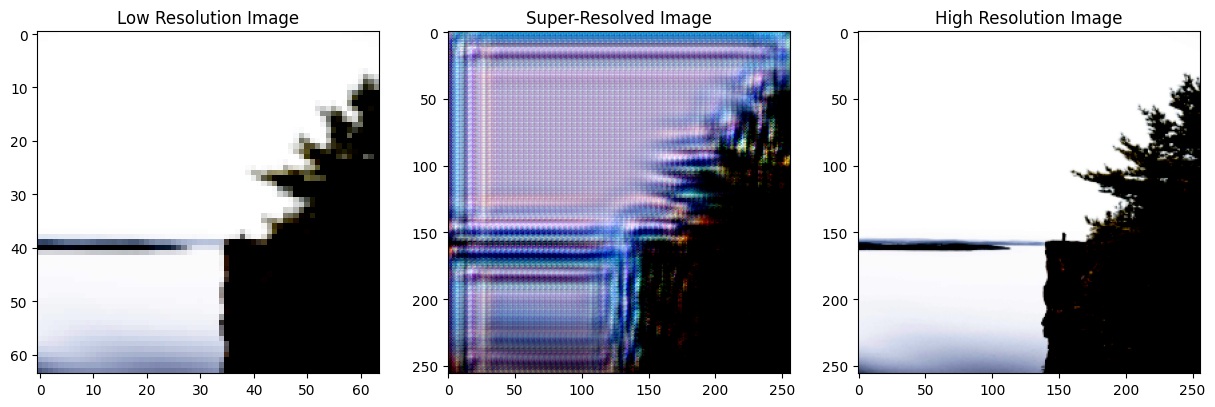

In [ ]:
import matplotlib.pyplot as plt
import random

# Set the random seed for reproducibility
random_sample = random.randint(0, len(dataset) - 1)

# Load the saved weights
generator.load_state_dict(torch.load(generator_path))
discriminator.load_state_dict(torch.load(discriminator_path))

# Get a sample from the dataset
lr_image, hr_image = dataset[random_sample]

# Add a batch dimension
lr_image = lr_image.unsqueeze(0).to(device)

# Generate the super-resolved image
with torch.no_grad():
  sr_image = generator(lr_image)

# Remove the batch dimension
lr_image = lr_image.squeeze(0).cpu()
sr_image = sr_image.squeeze(0).cpu()
hr_image = hr_image.cpu()

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(lr_image.permute(1, 2, 0))
axes[0].set_title('Low Resolution Image')
axes[1].imshow(sr_image.permute(1, 2, 0))
axes[1].set_title('Super-Resolved Image')
axes[2].imshow(hr_image.permute(1, 2, 0))
axes[2].set_title('High Resolution Image')
plt.show()
